# Cross-Modal Video Search with TwelveLabs and Pixeltable

TwelveLabs' [Marengo](https://docs.twelvelabs.io/docs/marengo) model projects text, images, audio, and video into the same semantic space. That means a text description, a still frame, an audio clip, and a video segment of the same moment all land near each other in the embedding space — and you can search across all of them with a single index.

| Query Type | Use Case |
|------------|----------|
| **Text → Video** | Find clips matching "a man giving a speech" |
| **Image → Video** | Find videos visually similar to a reference photo |
| **Audio → Video** | Find videos with similar speech or sounds |
| **Video → Video** | Find similar clips or alternative takes |

This notebook walks through all four, then shows how the same embeddings apply to non-video data like text and images.

### Prerequisites

- A TwelveLabs API key from [playground.twelvelabs.io](https://playground.twelvelabs.io/)
- Audio and video content must be at least 4 seconds long

## Setup

In [ ]:
%pip install -qU pixeltable twelvelabs

In [1]:
import pixeltable as pxt
import pixeltable.functions as pxtf

pxt.drop_dir('twelvelabs_demo', force=True)
pxt.create_dir('twelvelabs_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'twelvelabs_demo'.


/Users/alison-pxt/Documents/Github/mm-demo/.venv/lib/python3.12/site-packages/pixeltable/env.py:494: UserWarning: Progress reporting is disabled because ipywidgets is not installed. To fix this, run: `pip install ipywidgets`
  warnings.warn(


In [4]:
from pixeltable.config import Config
print(Config.get().get_value('api_key', str, section='twelvelabs'))

tlk_20YHK7S34ZGH3J23267QT2MCZ5MR


In [3]:
# this will work 100% of the time
import os
os.environ['TWELVELABS_API_KEY'] = 'tlk_20YHK7S34ZGH3J23267QT2MCZ5MR'

## Cross-Modal Video Search

The workflow has three steps: create a table, split the video into segments, and build an embedding index. After that, every search modality works through the same `.similarity()` interface.

### Create a video table

In [5]:
# Create a table for videos
half = pxt.create_table('twelvelabs_demo.halftime_show', {'video': pxt.Video})

Created table 'halftime_show'.


This is an empty table with a schema for now. In this notebook, we'll revisit the table schema as we build up our workflow.

In [6]:
half

table 'twelvelabs_demo/halftime_show'

 Column Name   Type Computed With
       video  Video

We can insert many rows of video files at this point into the table - videos can be referenced wherever they are actually stored:

- Local paths (this example)
- HTTP URLs
- Cloud storage (like S3, GCS)

In [7]:
# Insert the 5-minute clip (created by create_clip.py from the full video)
video_url = 'media/clip-lx-halftime-show.mp4'
half.insert([{'video': video_url}])

Inserted 1 row with 0 errors in 0.08 s (11.97 rows/s)


1 row inserted.

In Pixeltable, we use `collect()` to view a table's contents. You can also use `head(n)` or `tail(n)` for bigger tables to print just a few rows. You could also combine `limit(n).collect()`. But here we have just 1 video in our dataset to start.

video
""

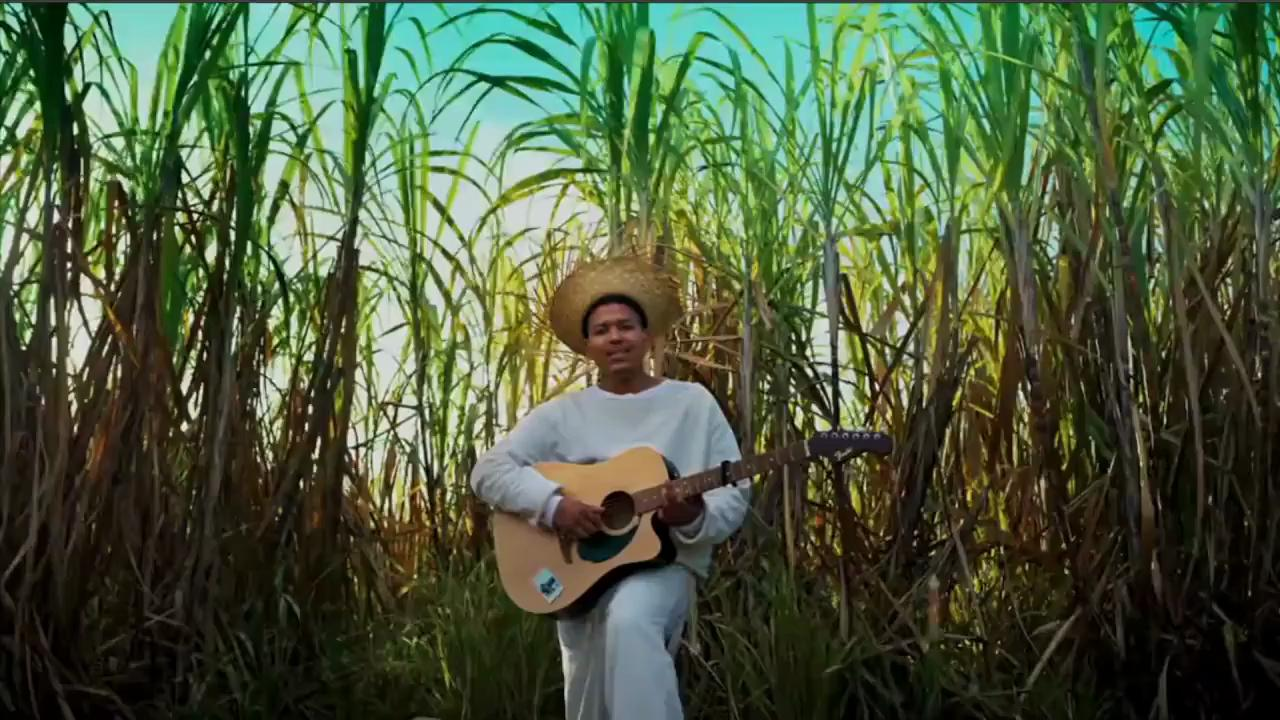

In [8]:
half.collect()

### Split the video into segments

Views are a core concept in Pixeltable, and in addition to computed columns, are another way to add a different level or orchestration to your table. 

Views are powerful on their own, as they allow you to create a derived table on top of a base table. That table could be filtered by a column value, or some other subset of rows, so you can quickly experiment with expensive operations on a subset of your dataset.

Pixeltable also provides a special kind of view called an iterator view, which we'll use here. It enables you to essentially expand your base table. Imagine a view that chunks a document, splits text by sentences, chops audio files up into clips, or here, we'll split a video into 15-second segments. You can get pretty creative here and even split videos into scenes based on scene detection.

In [9]:
# Split into segments (TwelveLabs requires at least 4 seconds)
video_chunks = pxt.create_view(
    'twelvelabs_demo.video_chunks',
    half,
    iterator=pxtf.video.video_splitter(
        video=half.video,
        duration=15.0, 
        min_segment_duration=4.0
    ),
    if_exists='replace'
)

In [10]:
video_chunks.count()

20

We can peek at the first few rows. When we create an iterator view like this, you can see that Pixeltable does an implicit join on the parent table, so we have the source video on every row. This data is not duplicated though.

pos,segment_start,segment_start_pts,segment_end,segment_end_pts,video_segment,video
0,0.,0,23.333,358400,,
1,23.333,358400,31.433,482816,,
2,31.433,482816,53.333,819200,,

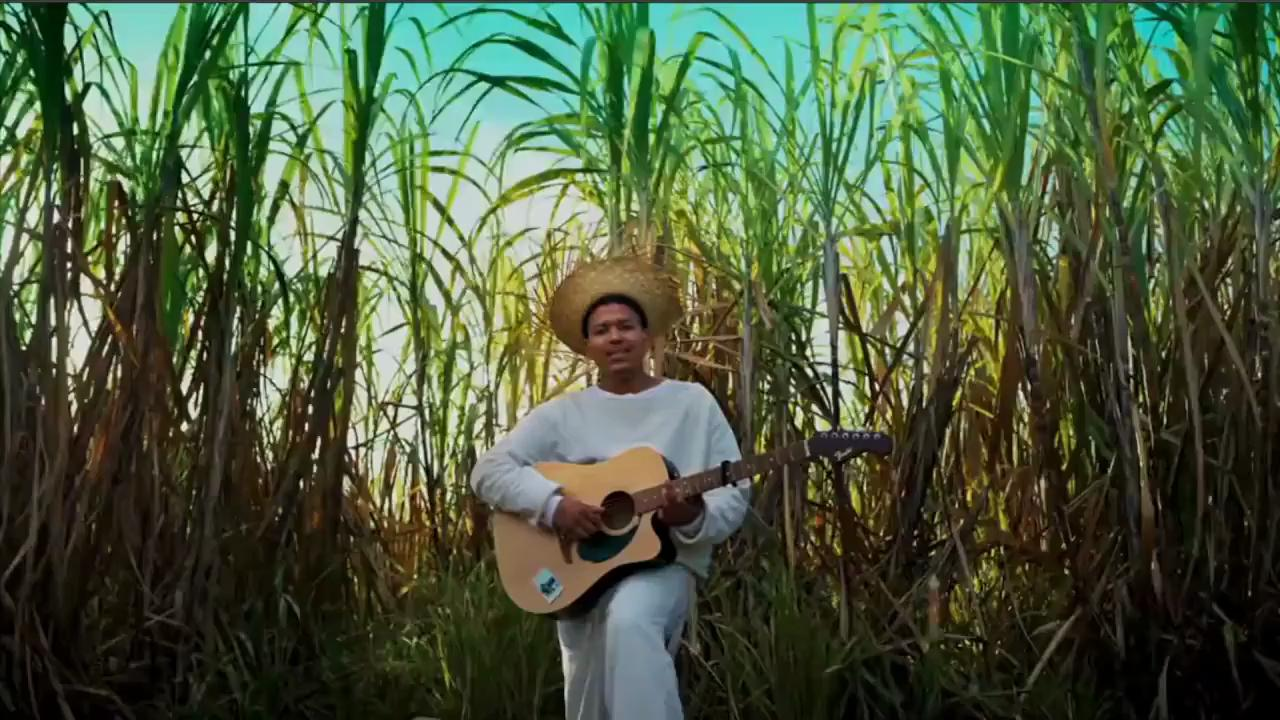
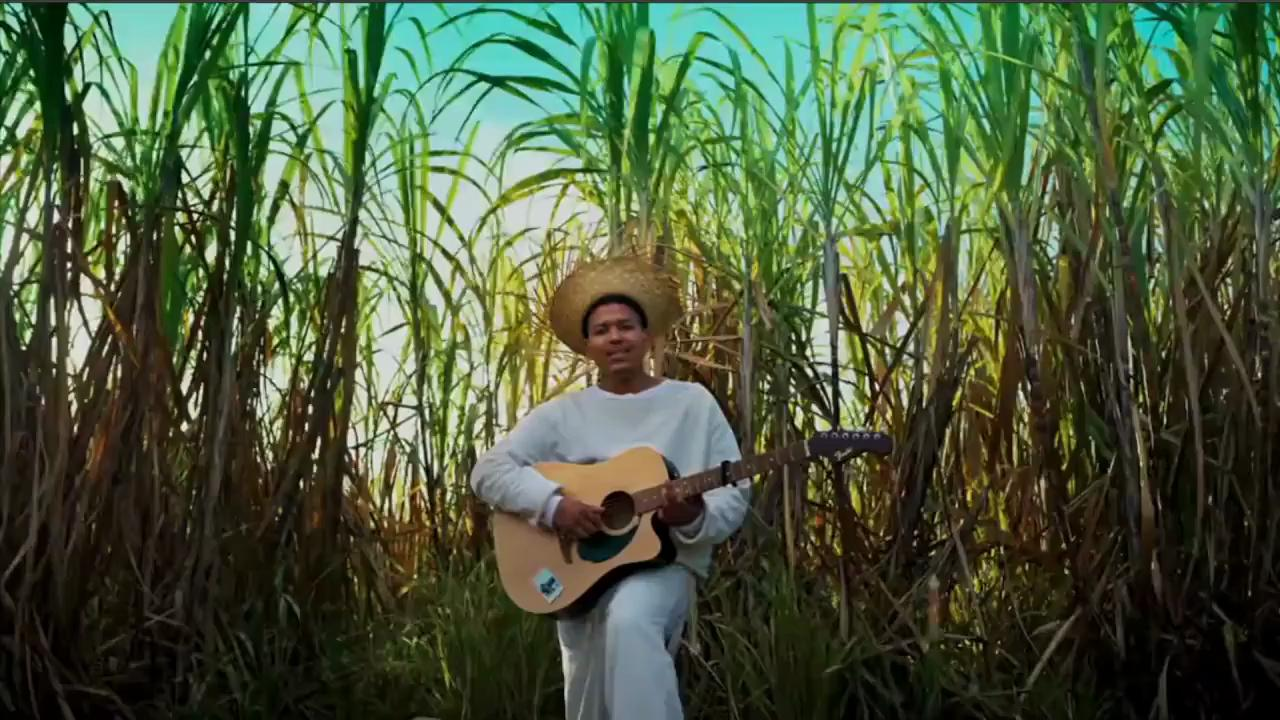
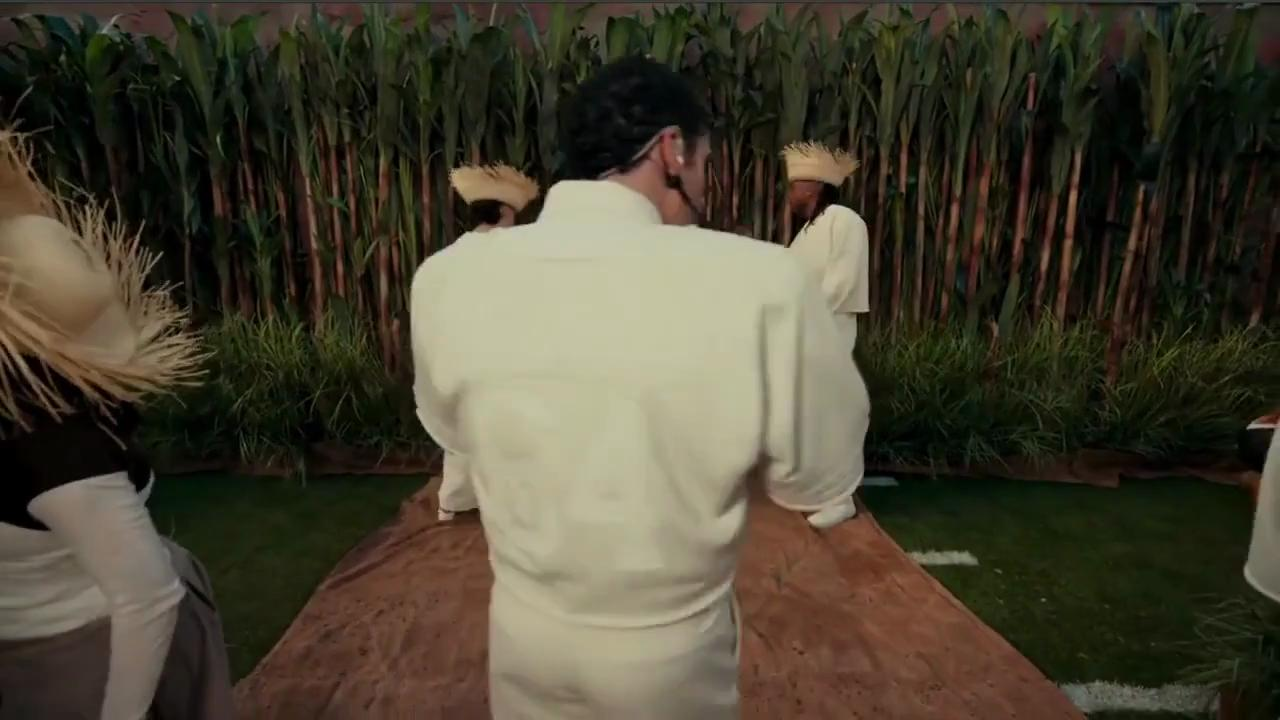
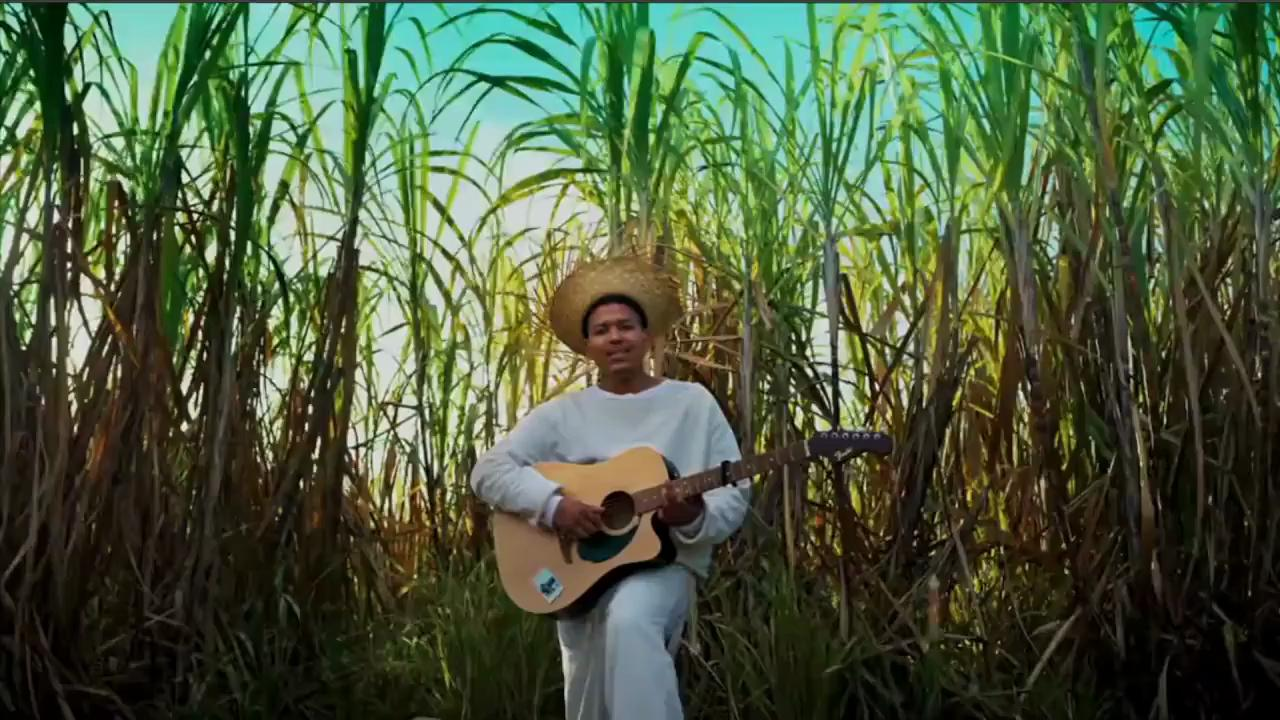
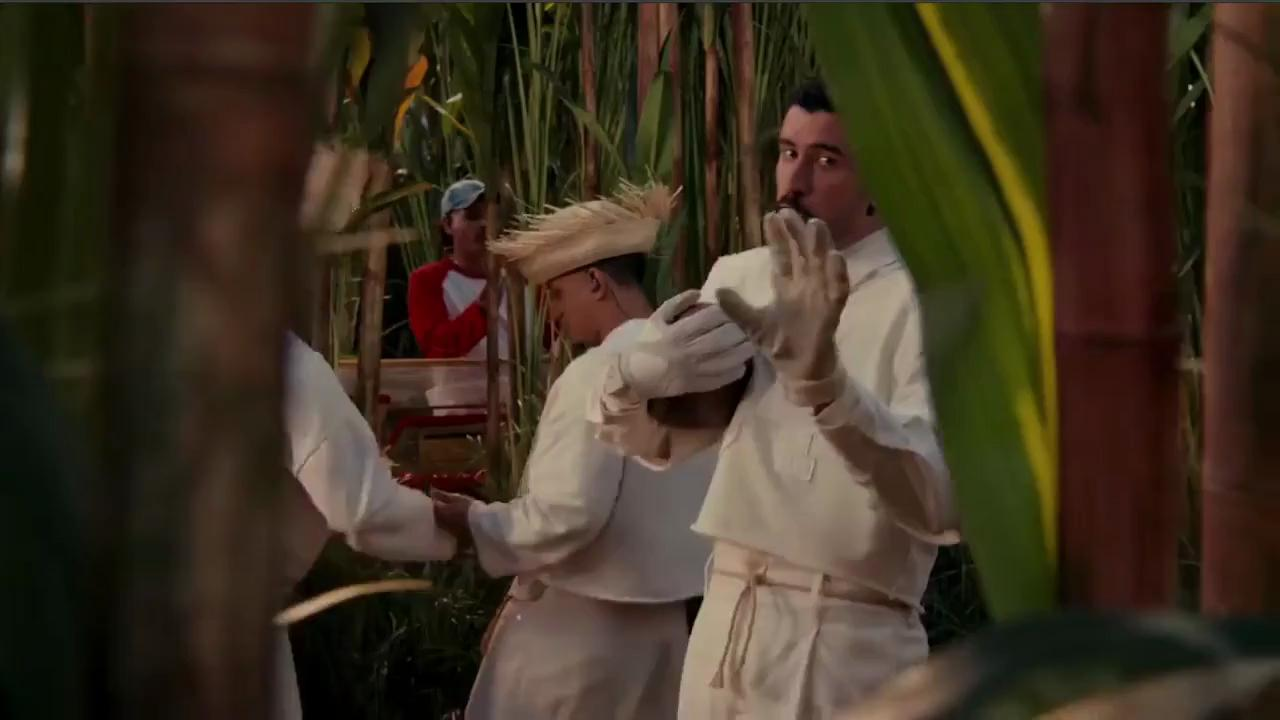
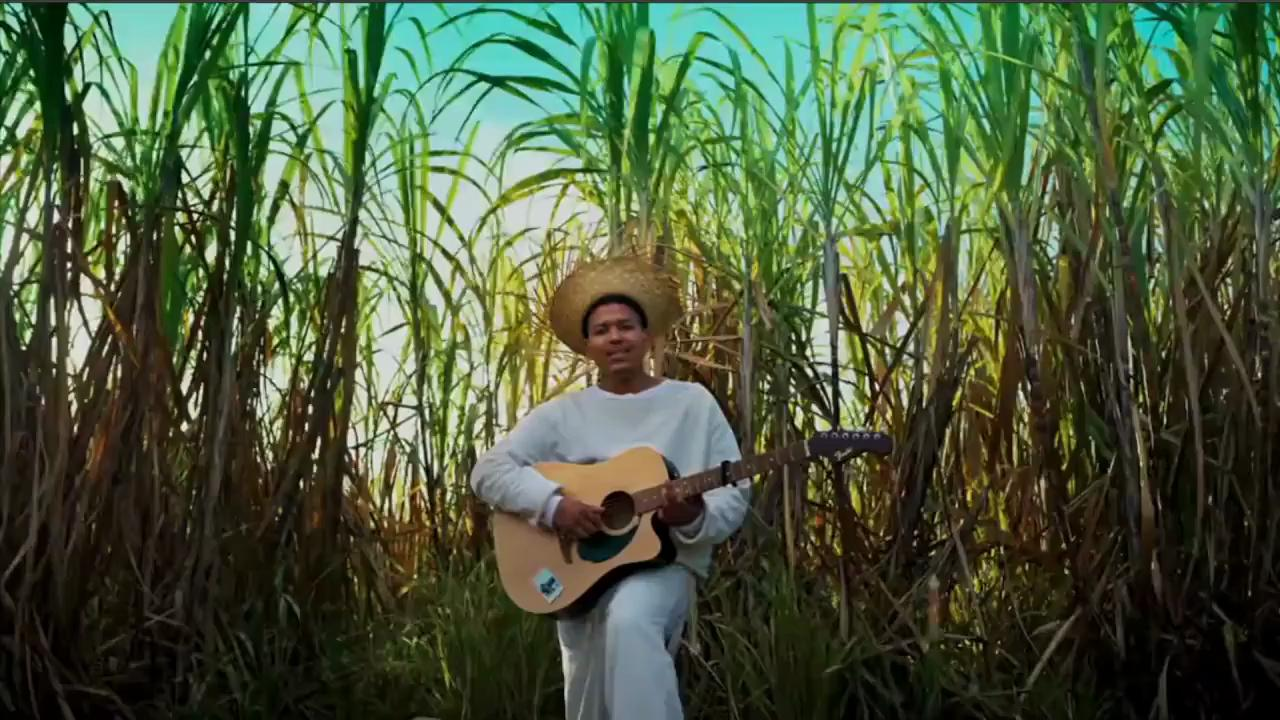

In [11]:
video_chunks.head(3)

Let's check out the scheme for our iterator view.

In [12]:
video_chunks

view 'twelvelabs_demo/video_chunks' (of 'twelvelabs_demo/halftime_show')

        Column Name             Type Computed With
                pos    Required[Int]              
      segment_start            Float              
  segment_start_pts              Int              
        segment_end            Float              
    segment_end_pts              Int              
      video_segment  Required[Video]              
              video            Video

### Build the embedding index using TwelveLabs Marengo

In [ ]:
video_chunks.add_embedding_index(
    video_chunks.video_segment,
    embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0'),
    if_exists='replace'
)

In [ ]:
video_chunks

That's it for setup. Pixeltable sent each segment to the TwelveLabs Embed API, stored the 512-dimensional vectors, and built a searchable index. When new videos are inserted later, the index updates incrementally.

## Cross-modal video search

### Search #1: Text to Video

The `.similarity()` method on an indexed column returns an expression that works in `order_by`, `select`, and `where` clauses. For text queries, pass the `string=` argument.

In [ ]:
sim = video_chunks.video_segment.similarity(string='violinists playing')

video_chunks.order_by(sim, asc=False).limit(3).select(
    video_chunks.video_segment, score=sim
).collect()

### Search #2: Image to Video

The same index handles image queries. Here we use a screenshot from the video as the reference — Pixeltable finds the segments that are visually closest to it.

In [ ]:
image_query = 'media/qry-img-grass.jpg'

sim = video_chunks.video_segment.similarity(image=image_query)

video_chunks.order_by(sim, asc=False).limit(3).select(
    video_chunks.video_segment, score=sim
).collect()

### Search #3: Audio to Video

An audio clip works the same way — useful for matching speech patterns, background music, or ambient sounds.

In [ ]:
audio_query = 'media/aud-yo-perreo-sola.wav'

sim = video_chunks.video_segment.similarity(audio=audio_query)

video_chunks.order_by(sim, asc=False).limit(3).select(
    video_chunks.video_segment, score=sim
).collect()

### Search #4: Video to Video

A video segment or clip can also be the query. This is the basis for recommendations, duplicate detection, or finding alternative takes.

In [ ]:
video_query = 'media/qry-video-clip.mp4'

sim = video_chunks.video_segment.similarity(video=video_query)

video_chunks.order_by(sim, asc=False).limit(3).select(
    video_chunks.video_segment, score=sim
).collect()

## Narrowing the Embedding Context

For video embeddings, Marengo can focus on specific aspects of the content:

- `'visual'` — what you see
- `'audio'` — what you hear
- `'transcription'` — what is said

By default, Marengo uses all three. If your use case only cares about one aspect — say, matching visual style regardless of dialogue — you can narrow the embedding.

In [ ]:
# Add a visual-only embedding as a computed column
video_chunks.add_computed_column(
    visual_embedding=pxtf.twelvelabs.embed(
        video_chunks.video_segment,
        model_name='marengo3.0',
        embedding_option=['visual'],
    )
)

video_chunks.select(
    video_chunks.video_segment, video_chunks.visual_embedding
).limit(2).collect()

## Beyond Video: Text, Images, and Documents

TwelveLabs embeddings aren't limited to video. The same Marengo model embeds text and images, which means you can build a single table with multiple embedding indexes — one per column — and search across modalities.

In [ ]:
# A content table with text and image columns
content = pxt.create_table(
    'twelvelabs_demo.content',
    {
        'title': pxt.String,
        'description': pxt.String,
        'thumbnail': pxt.Image,
    },
)

# Embedding index on the text column
content.add_embedding_index(
    idx_name='desc_idx',
    column=content.description, 
    embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0')
)

# Embedding index on the image column
content.add_embedding_index(
    idx_name='thumb_idx',
    column=content.thumbnail, 
    embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0')
)

In [ ]:
content.insert([
    {
        'title': 'Beach Sunset',
        'description': 'A beautiful sunset over the ocean with palm trees.',
        'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000025.jpg',
    },
    {
        'title': 'Mountain Hiking',
        'description': 'Hikers climbing a steep mountain trail with scenic views.',
        'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000139.jpg',
    },
    {
        'title': 'City Street',
        'description': 'Busy urban street with cars and pedestrians.',
        'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000042.jpg',
    },
    {
        'title': 'Wildlife Safari',
        'description': 'Elephants and zebras on the African savanna.',
        'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000061.jpg',
    },
])

In [ ]:
# Search by text description
sim = content.description.similarity(string='outdoor nature adventure')

content.order_by(sim, asc=False).limit(2).select(
    content.title, content.description, score=sim
).collect()

In [ ]:
# Search by image similarity
query_image = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000001.jpg'

sim = content.thumbnail.similarity(image=query_image)

content.order_by(sim, asc=False).limit(2).select(
    content.title, content.thumbnail, score=sim
).collect()

In [ ]:
# Cross-modal: search images using text
sim = content.thumbnail.similarity(string='animals in the wild')

content.order_by(sim, asc=False).limit(2).select(
    content.title, content.thumbnail, score=sim
).collect()

That last query is worth pausing on. The embedding index was built on an image column, but the search query is text. Because Marengo puts both modalities in the same vector space, this works without any extra configuration — no separate text model, no alignment step.

## Summary

The pattern is the same throughout: create a table, add an embedding index, and search with `.similarity()`. The query modality — text, image, audio, or video — is an argument, not a different API.

A few things to keep in mind:

- **Embedding options** let you focus on visual, audio, or transcription aspects of video content
- **Multiple indexes per table** work on different columns (text, image, etc.) with the same model
- **Incremental updates** happen automatically — inserting new rows recomputes only the new embeddings
- **Similarity thresholds** in `.where()` clauses help control precision vs. recall

### Learn More

- [TwelveLabs Documentation](https://docs.twelvelabs.io/)
- [Pixeltable Documentation](https://docs.pixeltable.com/)
- [Pixeltable GitHub](https://github.com/pixeltable/pixeltable)